<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/06_transfer_learning_in_tensor_flow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision Mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of Food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.


In [1]:
# Check to see if we're using a GPU?
!nvidia-smi

Fri Aug 13 15:21:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-13 15:21:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-13 15:21:08 (86.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the imge_data_modification notebook.

In [4]:
# Downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
unzip_data("101_food_classes_10_percent.zip")

--2021-08-13 15:21:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   214MB/s    in 7.1s    

2021-08-13 15:21:21 (218 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# Setup directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
# How many images, classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/risotto'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/eggs_benedict'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_c

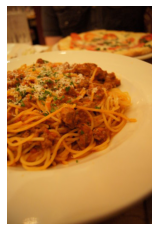

In [7]:
# Visualizing random images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
random_class = random.choice(os.listdir(train_dir))
img_path = train_dir + random_class
random_img = random.choice(os.listdir(img_path))
img = img_path + "/" + random_img
img = mpimg.imread(img)
plt.imshow(img)
plt.axis(False);

In [8]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 Food Classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature Extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to  save epoch time)

In [9]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True,
                                                         save_best_only=True)

In [10]:
# Create data augmentation layer to incorporate it right into our model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
],name="data_augmentation")

In [11]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# Passing through data augmentation layer
x = data_augmentation(inputs) # augment images (only happens during training phase)

# Passing into the base model
x = base_model(x, training = False) # put the base model in inference mode so weights which needs to stay frozen, stays frozen

# Passing through Pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

# Create the outputs
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs,outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
# Get a summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
# Compile the model

model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [15]:
# Fit the model
history_0 = model.fit(train_data_all_10_percent,
                      epochs=5,
                      steps_per_epoch = len(train_data_all_10_percent),
                      validation_data = test_data,
                      validation_steps = int(0.15 * len(test_data)),
                      callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 91s 360ms/step - loss: 3.4896 - accuracy: 0.2399 - val_loss: 2.6567 - val_accuracy: 0.4102
Epoch 2/5
237/237 [==============================] - 71s 297ms/step - loss: 2.3872 - accuracy: 0.4541 - val_loss: 2.1960 - val_accuracy: 0.4759
Epoch 3/5
237/237 [==============================] - 66s 276ms/step - loss: 2.0079 - accuracy: 0.5212 - val_loss: 2.0406 - val_accuracy: 0.4923
Epoch 4/5
237/237 [==============================] - 61s 256ms/step - loss: 1.7954 - accuracy: 0.5605 - val_loss: 1.9473 - val_accuracy: 0.5132
Epoch 5/5
237/237 [==============================] - 59s 247ms/step - loss: 1.6370 - accuracy: 0.5968 - val_loss: 1.9036 - val_accuracy: 0.5101


In [16]:
# Evaluate on the full test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 90s 114ms/step - loss: 1.7185 - accuracy: 0.5536


[1.7185137271881104, 0.5536237359046936]

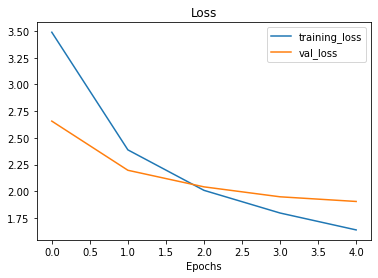

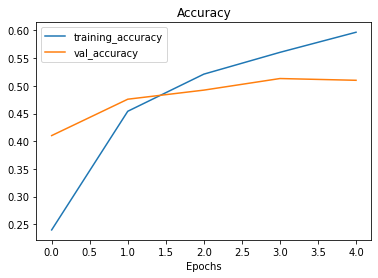

In [17]:
# Plotting loss curves
plot_loss_curves(history_0)

**Question:** What do these curves suggest? 
Hint: Ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine Tuning

In [18]:
# Unfreeze all of the layers in base model
base_model.trainable = True

# Re-freeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [19]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
    metrics=["accuracy"]
)

In [20]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [21]:
# Check which layers in our base model is trainable?
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [22]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has done already 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_1 = model.fit(train_data_all_10_percent,
                      epochs = fine_tune_epochs,
                      validation_data = test_data,
                      validation_steps = int(0.15 * len(test_data)),
                      initial_epoch = history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 68s 259ms/step - loss: 1.4030 - accuracy: 0.6382 - val_loss: 1.9243 - val_accuracy: 0.4981
Epoch 6/10
237/237 [==============================] - 56s 235ms/step - loss: 1.2780 - accuracy: 0.6675 - val_loss: 1.9205 - val_accuracy: 0.5000
Epoch 7/10
237/237 [==============================] - 54s 228ms/step - loss: 1.1992 - accuracy: 0.6832 - val_loss: 1.8800 - val_accuracy: 0.5138
Epoch 8/10
237/237 [==============================] - 55s 229ms/step - loss: 1.1169 - accuracy: 0.7064 - val_loss: 1.8692 - val_accuracy: 0.5169
Epoch 9/10
237/237 [==============================] - 53s 221ms/step - loss: 1.0825 - accuracy: 0.7100 - val_loss: 1.8318 - val_accuracy: 0.5310
Epoch 10/10
237/237 [==============================] - 52s 219ms/step - loss: 1.0218 - accuracy: 0.7300 - val_loss: 1.9029 - val_accuracy: 0.5159


In [23]:
# Evaluate on the whole test data
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 89s 112ms/step - loss: 1.6103 - accuracy: 0.5770


[1.6102983951568604, 0.5770297050476074]

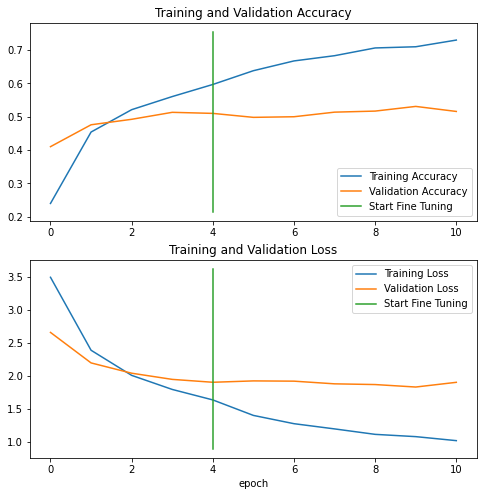

In [24]:
# Compare the histories of feature extraction model with fine tuning model
compare_historys(original_history=history_0, new_history=history_1, initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [25]:
# Save our fine-tuned model
model.save("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model/assets


**Note:** Loading the model with the following cell will output a large amount of warnings, there is a thread tracking this issue on Github: https://github.com/tensorflow/tensorflow/issues/40166. However, it seems according to the TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [26]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_saved_big_dog_model")

In [27]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 90s 113ms/step - loss: 1.6103 - accuracy: 0.5770


[1.6102983951568604, 0.5770297050476074]

In [28]:
# The results from our loaded model (above) should be very similar to the results below
fine_tune_results

[1.6102983951568604, 0.5770297050476074]

## Evaluating the performance of the big dog model accross all different classes

Let's make some predictions, visualize them and them later find out which predictions were the "most" wrong.

In [29]:
import tensorflow as tf

# Download pre-trained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-08-13 15:48:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   146MB/s    in 0.3s    

2021-08-13 15:48:34 (146 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [30]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [31]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [32]:
# Evaluate loaded model (the one we just downloaded)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 92s 115ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [33]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 64s 79ms/step


In [34]:
# How many predictions re there and what's the shape of our predictions?
len(pred_probs), pred_probs.shape

(25250, (25250, 101))

In [35]:
# Check for first prediction
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.9542008e-02, 3.5741950e-06, 4.1376859e-02, 1.0660556e-09,
        8.1613978e-09, 8.6639664e-09, 8.0926822e-07, 8.5652499e-07,
        1.9859017e-05, 8.0977776e-07, 3.1727747e-09, 9.8673661e-07,
        2.8532164e-04, 7.8049051e-10, 7.4230169e-04, 3.8916416e-05,
        6.4740193e-06, 2.4977280e-06, 3.7891099e-05, 2.0678388e-07,
        1.5538422e-05, 8.1506943e-07, 2.6230446e-06, 2.0010630e-07,
        8.3827456e-07, 5.4215989e-06, 3.7390860e-06, 1.3150533e-08,
        2.7761406e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
        1.6688865e-04, 7.6407297e-10, 4.0452729e-04, 1.3150634e-08,
        1.7957379e-06, 1.4448218e-06, 2.3062859e-02, 8.2466784e-07,
        8.5365781e-07, 1.7138614e-06, 7.0525107e-06, 1.8402169e-08,
        2.8553407e-07, 7.9483234e-06, 2.0681514e-06, 1.8525066e-07,
        3.3619774e-08, 3.1522498e-04, 1.0410913e-05, 8.5448539e-07,
        8.4741873e-01, 1.0555415e-05, 4.4094671e-07, 3.7404148e-05,
        3.5306231e-05, 3.2489133e-05, 6.7314817e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [36]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542008e-02 3.5741950e-06 4.1376859e-02 1.0660556e-09 8.1613978e-09
 8.6639664e-09 8.0926822e-07 8.5652499e-07 1.9859017e-05 8.0977776e-07
 3.1727747e-09 9.8673661e-07 2.8532164e-04 7.8049051e-10 7.4230169e-04
 3.8916416e-05 6.4740193e-06 2.4977280e-06 3.7891099e-05 2.0678388e-07
 1.5538422e-05 8.1506943e-07 2.6230446e-06 2.0010630e-07 8.3827456e-07
 5.4215989e-06 3.7390860e-06 1.3150533e-08 2.7761406e-03 2.8051838e-05
 6.8562162e-10 2.5574835e-05 1.6688865e-04 7.6407297e-10 4.0452729e-04
 1.3150634e-08 1.7957379e-06 1.4448218e-06 2.3062859e-02 8.2466784e-07
 8.5365781e-07 1.7138614e-06 7.0525107e-06 1.8402169e-08 2.8553407e-07
 7.9483234e-06 2.0681514e-06 1.8525066e-07 3.3619774e-08 3.1522498e-04
 1.0410913e-05 8.5448539e-07 8.4741873e-01 1.0555415e-05 4.4094671e-07
 3.7404148e-05 3.5306231e-05 3.2489133e-05 6.7314817e-05 1.2852616e-08
 2.6219660e-10 1.0318080e-05 8.5744046e-05 1.

In [37]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [38]:
# How many pred_classes do we have?
len(pred_classes), pred_classes.shape

(25250, (25250,))

Now we've got predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels

In [39]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0,1,....0,0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

Streaming output truncated to the last 5000 lines.
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtyp

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [41]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [44]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [45]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [46]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

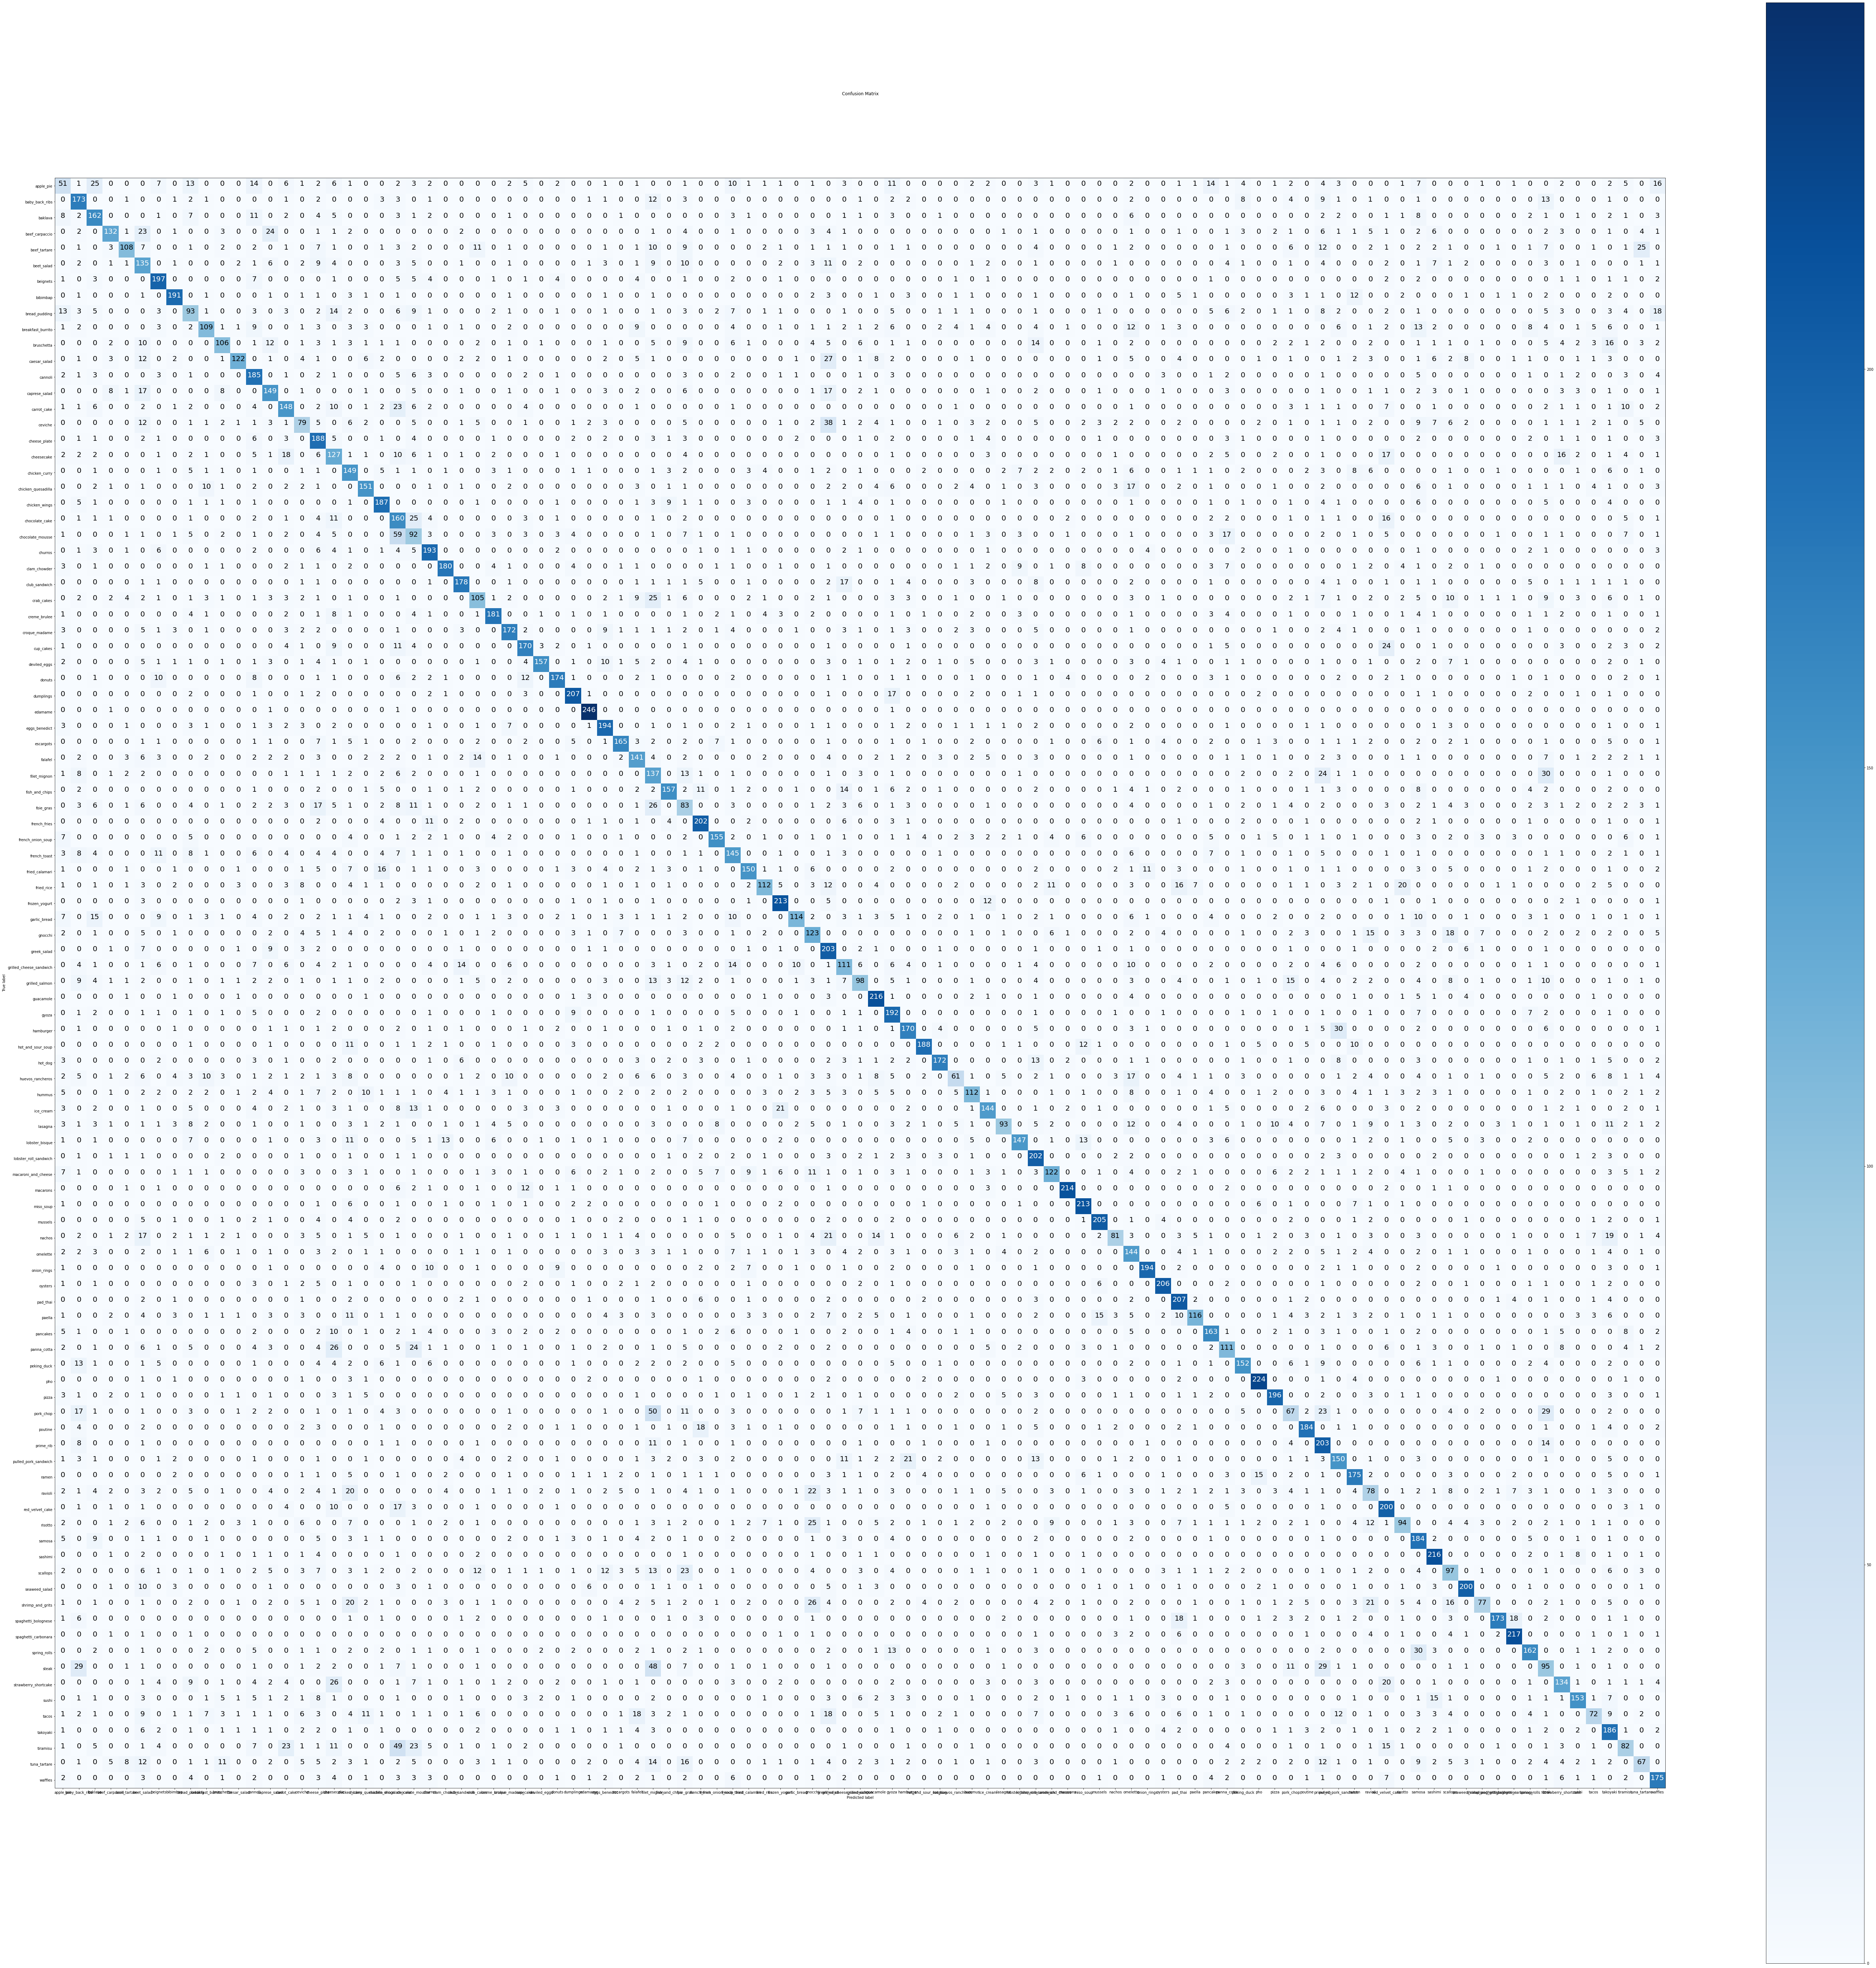

In [47]:
## Let's get visual: Making a confusion matrix
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_labels,pred_classes,class_names,
                      figsize=(100,100),text_size=20)

We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically

In [48]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

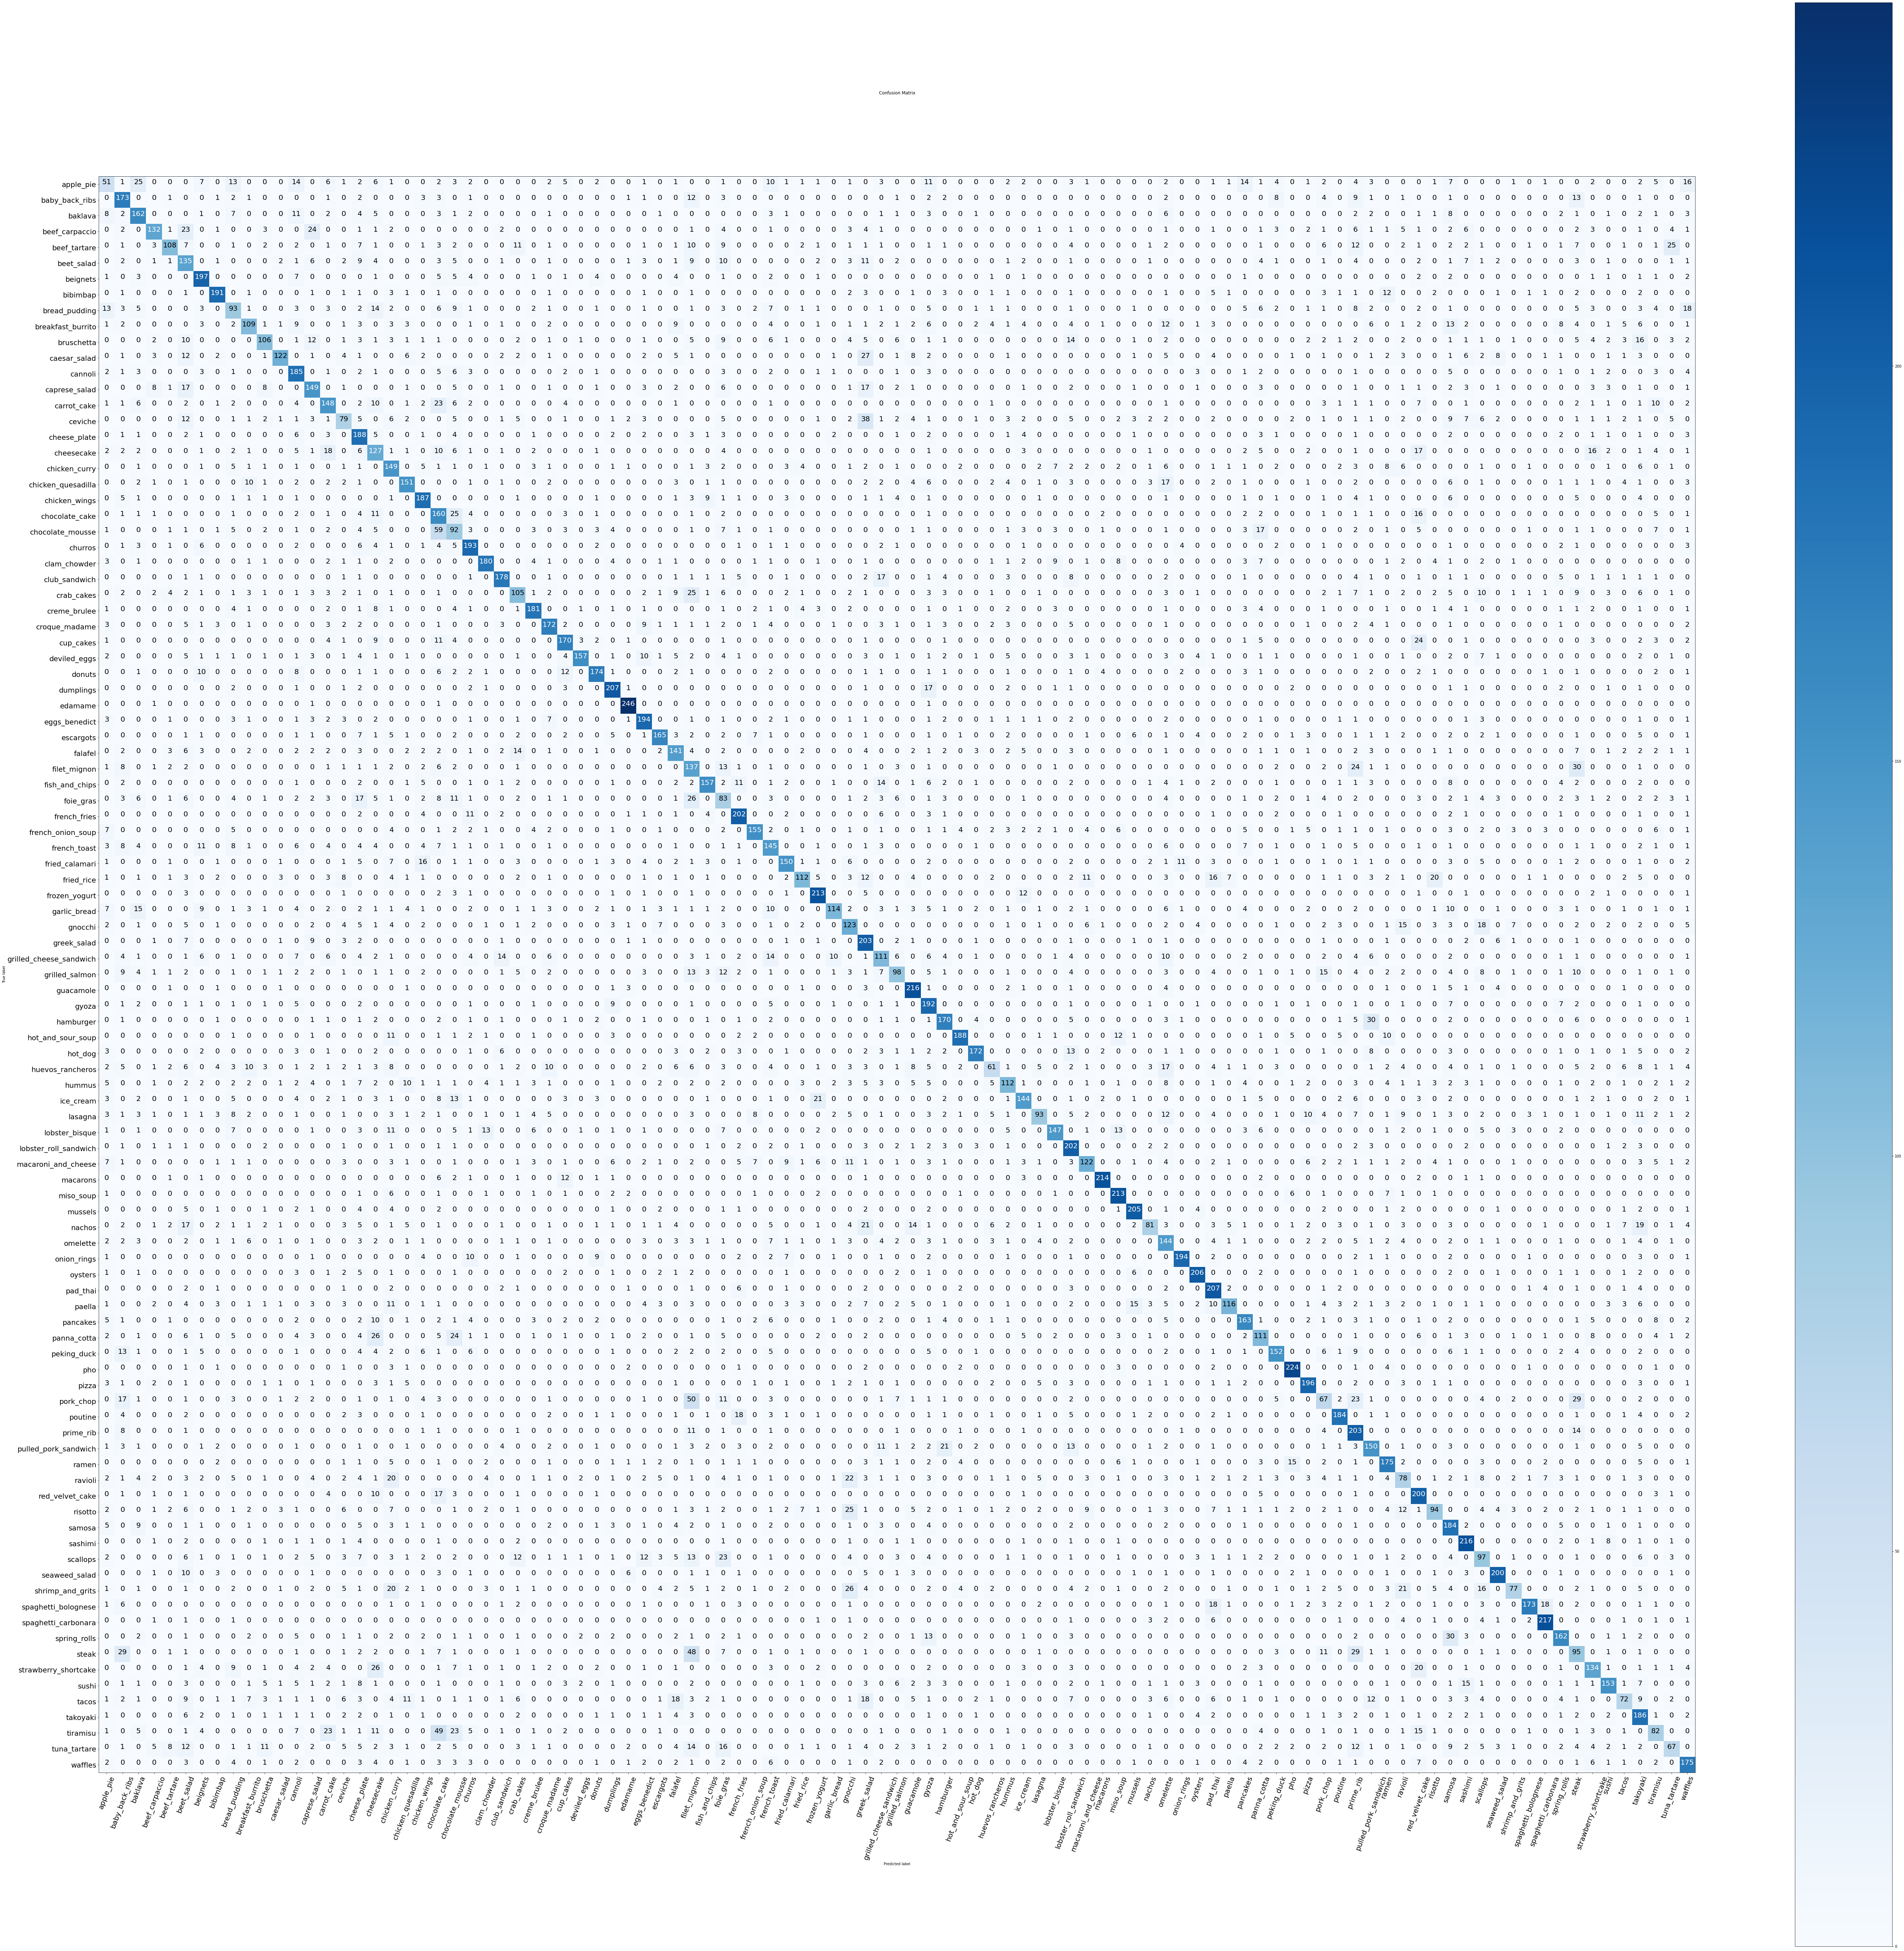

In [49]:
make_confusion_matrix(y_labels,pred_classes,class_names,
                      figsize=(100,100),text_size=20,savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-Learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F-1 score) called classification report.

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [52]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Let's plot all of our classses F1-scores....

In [55]:
len(class_names)

101

In [57]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for index, value in classification_report_dict.items():
  if index == "accuracy": ## stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(index)]] = value["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [59]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

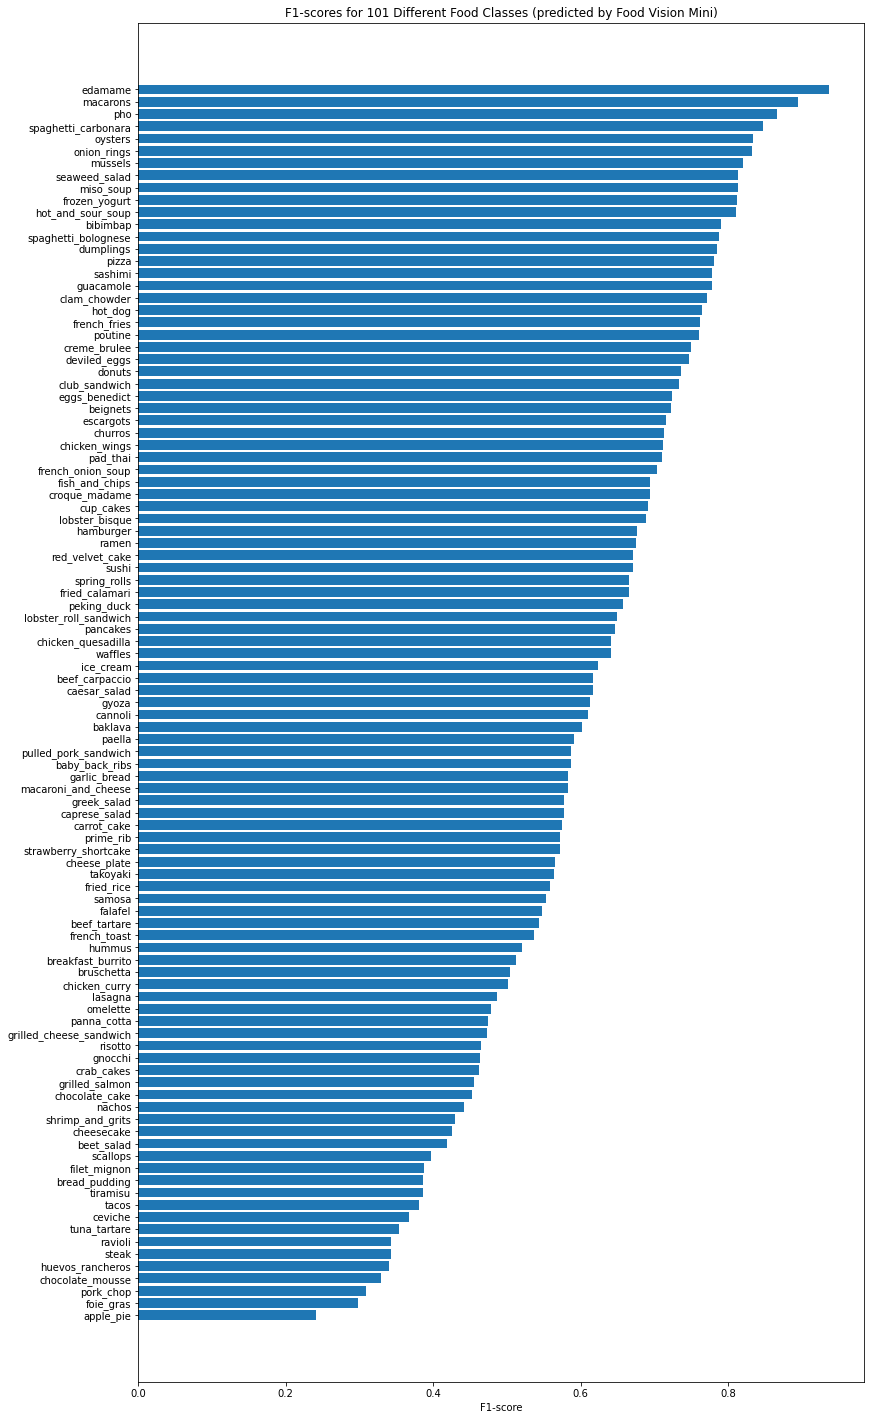

In [141]:
# Plot 
fig,ax = plt.subplots(figsize=(13,25))
scores = ax.barh(f1_scores["class_names"], f1_scores["f1-score"])
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision Mini)")
ax.set_xlabel("F1-score")
ax.invert_yaxis();

**Exercise:** Try visualizing some of the most poorly predicted classes (e.g. `apple_pie`, `foie_gras`), do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor usinf tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [163]:
# Create a function to load and prepare images
def preprocess_image(filepath, img_shape=224, scale=True):
  """
  Reads in an image from filepath, turns it into a tensor and reshapes into
  specified shape (img_shape,img_shape,color channels=3)

  Args:
  filepath (str): path to target image
  img_shape (int): height/width dimension of target image size
  scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (img_shape,img_shape,3)
  """
  # Read in the image
  img = tf.io.read_file(filepath)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  # Expand the dimensions
  # img = tf.expand_dims(img, axis=0)

  # Rescale the image (Yes/No)
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target labels and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

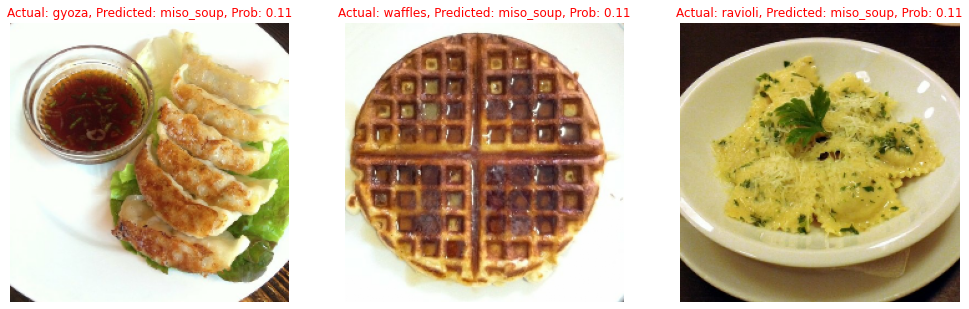

In [184]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose random image(s) from random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = preprocess_image(filepath=filepath, img_shape=224, scale=True)
  img_expanded = tf.expand_dims(img,axis=0)
  pred_prob = model.predict(img_expanded) # get prediction probabiities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it with class_name list

  # Plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img)
  if class_name == pred_class: # if predicted class matches truth class, make text blue
    title_color='b'
  else:
    title_color='r'
  plt.title(f"Actual: {class_name}, Predicted: {pred_class}, Prob: {pred_prob.max():.2f}", c= title_color)
  plt.axis(False);